In [5]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import qmc
import numpy.random as random
import vegas

In [2]:
class particle:
     def __init__(self, alive, mu, x, weight):
        self.alive = alive
        self.mu = mu
        self.x = x
        self.weight = weight

In [551]:
def mc_iso(sigmaS, sigmaA, q, W, L, N, UQ, ux):
    bins = 50
    flux = np.zeros(bins)  
    
    if UQ:
        x = np.linspace(0, L, bins)
        sigmaA = sigmaA + ux * np.sin(np.pi/6 * x) * np.random.randn()
    else:
        sigmaA = np.ones(bins) * sigmaA
        
    sigmaT = sigmaS + sigmaA

    for i in range(N):
        #create particle
        x = W * np.random.random()
        mu = 2 * np.random.random() - 1 #mu between -1 and 1
        p = particle(True, mu, x, q)

        while p.alive:
            #calculate distance to collision
            tally = int(p.x / L * bins)
            distance_to_collision = abs(-np.log(np.random.random())/sigmaT[tally])
            
            #calculate distance to boundary
            if p.mu < 0:
                distance_to_boundary = abs(p.x/p.mu)
            elif p.mu > 0:
                distance_to_boundary = (L-p.x)/p.mu
            
            
            #tally if distance to collision is greater than distance to boundary
            if distance_to_collision > distance_to_boundary:
                while distance_to_collision > distance_to_boundary:
                    distance_to_collision = distance_to_collision - distance_to_boundary
                    p.mu = -p.mu
                    if p.mu < 0:
                        distance_to_boundary = abs(p.x/p.mu)
                    elif p.mu > 0:
                        distance_to_boundary = (L-p.x)/p.mu
                    
                    
                #print(p.x, p.mu, distance_to_boundary, distance_to_collision)
                if p.mu > 0:
                    #p.mu = -p.mu
                    p.x = distance_to_collision * p.mu
                    #flux[0] += p.weight
                    #p.alive = False
                elif p.mu < 0:
                    #flux[bins-1] += p.weight
                    #p.mu = p.mu * -1
                    p.x = L + distance_to_collision * p.mu
                    #p.alive = False
                    
                
                tally = int(p.x / L * bins)
                if np.random.random() < sigmaA[tally]/sigmaT[tally]: #absorbed
                    tally = int(p.x / L * bins)
                    flux[tally] += p.weight
                    p.alive = False
                else: #isotropic scatter
                    p.mu = 2 * np.random.random() - 1
                           
            else:
                p.x += distance_to_collision * p.mu

                tally = int(p.x / L * bins)
                if np.random.random() < sigmaA[tally]/sigmaT[tally]: #absorbed
                    tally = int(p.x / L * bins)
                    flux[tally] += p.weight
                    p.alive = False
                else: #isotropic scatter
                    p.mu = 2 * np.random.random() - 1

    #return weighted sum and tally
    return flux / N

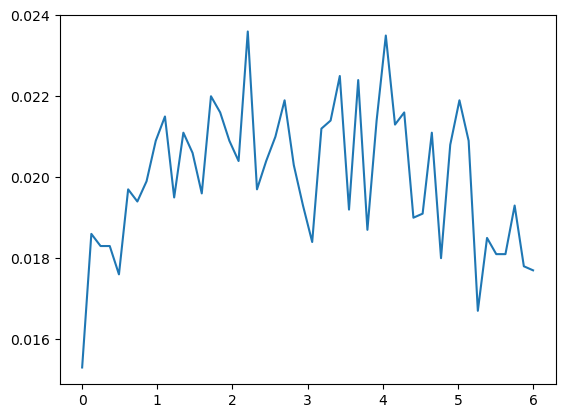

In [562]:
sigmaS = .1
sigmaA = 1
q = 1
L = 6
W = 6

tally = mc_iso(sigmaS, sigmaA, q, W, L, 10000, True, 1)
plt.plot(np.linspace(0,L,50), tally)

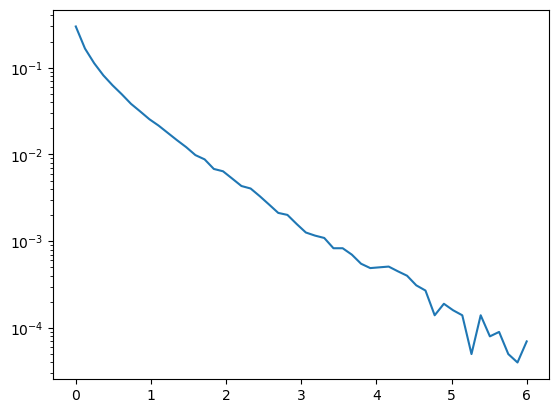

In [560]:
sigmaS = 0
sigmaA = 1
q = 1
L = 6
W = .1

tally = mc_iso(sigmaS, sigmaA, q, W, L, 100000, False, 1)
plt.plot(np.linspace(0,L,50), tally)
#plt.ylim((0,.02))
plt.yscale('log')
#plt.xscale('log')

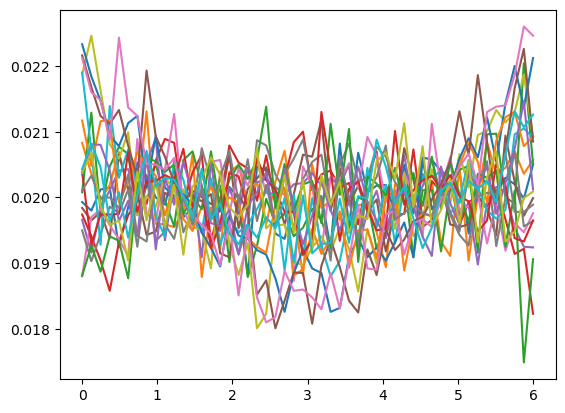

In [573]:
sigmaS = 0
sigmaA = 2
q = 1
L = 6
W = 6

for i in range(20):
    tally = mc_iso(sigmaS, sigmaA, q, W, L, 100000, True, .75)
    plt.plot(np.linspace(0,L,50), tally)

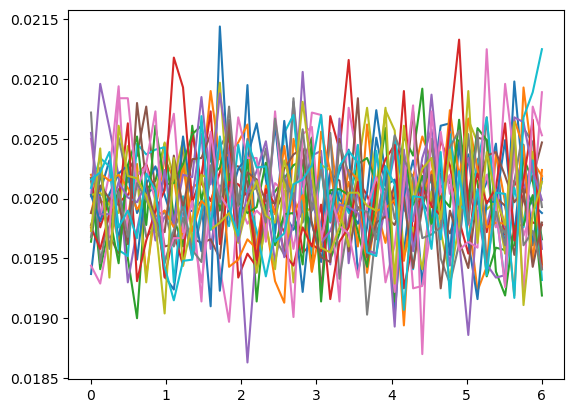

In [574]:
sigmaS = 0
sigmaA = 2
q = 1
L = 6
W = 6

for i in range(20):
    tally = mc_iso(sigmaS, sigmaA, q, W, L, 100000, False, 1)
    plt.plot(np.linspace(0,L,50), tally)

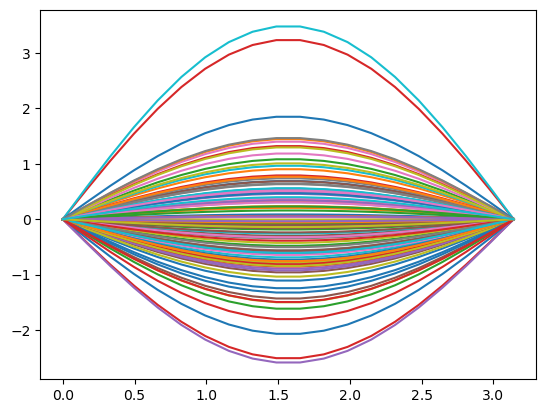

In [421]:
x = np.linspace(0,np.pi,20)
y = np.sin(x)
z = np.sin(x)

asdf = np.stack((y,z),axis=1)

for i in range(100):
    plt.plot(x,y*np.random.randn())
    #plt.scatter(y*np.random.randn(), z*np.random.randn())

array([[0.2791044 , 0.9356493 ],
       [0.62907685, 0.04934143]])

In [113]:
np.random.randn()

2.2165701991171463